In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:

!ls

drive  sample_data


In [ ]:
# %cd drive/MyDrive/Colab\ Notebooks/stanCode/final_project/data/

In [ ]:
%cd drive/MyDrive/Colab\ Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# FILE = "meta/data_info_v4.csv"

In [ ]:
FILE = "data_info_v4.csv"

# Transforms + Transfer learning + Fine tuning

In [ ]:
import os 
import math
import time
import glob
import pandas as pd
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, LinearSVR, SVC, SVR
from sklearn.metrics import confusion_matrix

In [ ]:
# See if GPU is available
# To turn GPU on: Edit -> Notebook Setting -> GPU

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

#### data browsing

In [ ]:
df = pd.read_csv(FILE, index_col=0)
df

In [ ]:
df.drop('Unnamed: 0.1',axis=1,inplace=True)
df

In [ ]:
df.describe()

In [ ]:
df.query("subset == 'val'")

In [ ]:
fig = plt.figure()
plt.hist(df["roadway_width"], np.linspace(0, 60, 13))

## Dataset + transforms

In [ ]:
class PedXingDataset(Dataset):
    
    def __init__(self, df_path, data_dir, subset, n=-1, dist_bin_size=5.0, verbose=False):
        self.df = pd.read_csv(df_path, index_col=0).query("subset == '{}'".format(subset))
        if n > 0:
            self.df = self.df.sample(n)
        self.n = len(self.df)
        self.dist_bin_size = dist_bin_size
        self.data_dir = data_dir
        self.verbose = verbose
        if subset == "train":
            self.transforms = transforms.Compose([                                 
                transforms.Resize(700),
                # transforms.CenterCrop(350),
                transforms.ToTensor(),  # 0-255 => 0.0 - 1.0
                # transforms.RandomInvert(p=0.5),
                transforms.RandomAffine(
                    degrees=3,
                    translate=(0.05, 0.05),
                    scale=(1.0, 1.2),
                ),
                # transforms.Normalize((0.485, 0.456, 0.406),
                #           (0.229, 0.224, 0.225)),
            ])
        else:
            self.transforms = transforms.Compose([
                transforms.Resize(700),
                # transforms.CenterCrop(400),                                  
                transforms.ToTensor(), # 0-255 => 0.0 - 1.0
                # transforms.Normalize((0.485, 0.456, 0.406),
                #                      (0.229, 0.224, 0.225)),
            ])
        
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        safe_to_walk,signal, roadway_width, crosswalk_signal, traffic_light, car, scooter, bike, other_obstacles, no_obstacle_in_crosswalk, weather = self.df.iloc[idx][[
            'safe_to_walk',                            
            'roadway_width',                                
            'crosswalk_signal',
            'traffic_light',
            'car',
            'scooter',
            'bike',
            'other_obstacles',
            'no_obstacle_in_crosswalk',
            'weather',
        ]]
        if self.verbose:
            print('safe_to_walk',safe_to_walk,
               'roadway_width',roadway_width
               'crosswalk_signal',signal, 
               'traffic_light',traffic_light
               'car', car, 
               'scooter',scooter,
               'bike',bike
               'other_obstacles',other_obstacles,
               'no_obstacle_in_crosswalk',no_obstacle_in_crosswalk,
               'weather',weather)
        
        y = torch.Tensor(self.df.iloc[idx][[
            'safe_to_walk',                            
            'roadway_width',                                
            'crosswalk_signal',
            'traffic_light',
            'car',
            'scooter',
            'bike',
            # 'other_obstacles',
            'no_obstacle_in_crosswalk',
            'weather',

        ]]).long()
        y[1] = torch.clamp(y[1] / self.dist_bin_size, 0, 7) # eqv. np.clip()
        x = Image.open(os.path.join(self.data_dir, self.df.iloc[idx]["new_filename"]))
        x = self.transforms(x)
        return x, y
    


#### training validation test set loader

In [ ]:
train_ds = PedXingDataset(FILE, data_dir="processed_data", subset="train", verbose=False)
val_ds = PedXingDataset(FILE, data_dir="processed_data", subset="val", verbose=False)

In [ ]:
test_ds = PedXingDataset(FILE, data_dir="processed_data", subset="test", verbose=False)

#### traning set browsing

In [ ]:
len(train_ds)
train_ds.df.iloc[0][[
            'safe_to_walk',                            
            'roadway_width',                                
            'crosswalk_signal',
            'traffic_light',
            'car',
            'scooter',
            'bike',
            # 'other_obstacles',
            'no_obstacle_in_crosswalk',
            'weather',
        ]]


In [ ]:
len(val_ds)

#### crosswalk signal

In [ ]:
fig = plt.figure()
plt.hist(df["crosswalk_signal"], np.linspace(0, 3, 4))

In [ ]:
df["crosswalk_signal"].value_counts()

In [ ]:
sign_cat_weight = 1.0 / df["crosswalk_signal"].value_counts().sort_index()
sign_cat_weight = sign_cat_weight / np.min(sign_cat_weight)
sign_cat_weight

#### weather

In [ ]:
fig = plt.figure()
plt.hist(df["weather"], np.linspace(0, 3, 4))

In [ ]:
df["weather"].value_counts()

In [ ]:
weather_cat_weight = 1.0 / df["weather"].value_counts().sort_index()
weather_cat_weight = weather_cat_weight / np.min(weather_cat_weight)
weather_cat_weight

#### roadway width

In [ ]:
df["roadway_cat"] = np.clip(np.floor(df["roadway_width"] / 5.0), 0, 7)
df["roadway_cat"] = df["roadway_cat"].apply(int)
df["roadway_cat"].value_counts()

In [ ]:
fig = plt.figure()
plt.hist(df["roadway_cat"], np.linspace(0, 8, 9))

In [ ]:
roadway_cat_weight = 100.0 / df["roadway_cat"].value_counts().sort_index()
roadway_cat_weight

#### traffic light

In [ ]:
df['traffic_light'].value_counts()

In [ ]:
traffic_light_cat_weight = 1.0 / df["traffic_light"].value_counts().sort_index()
traffic_light_cat_weight = traffic_light_cat_weight / np.min(traffic_light_cat_weight)
traffic_light_cat_weight

In [ ]:
x, y = train_ds[0]
x.size()

In [ ]:
y

#### image browsing

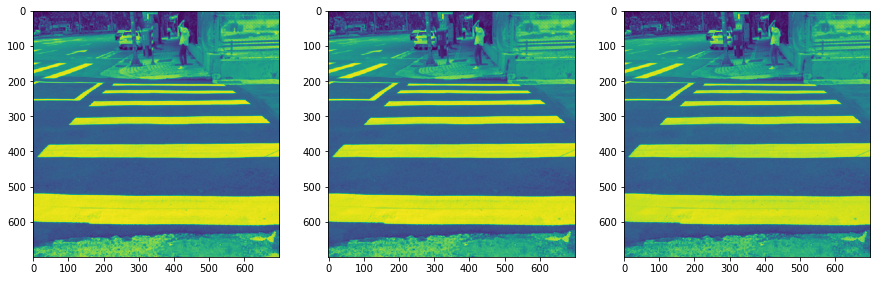

In [ ]:
fig = plt.figure()
fig.set_size_inches(15, 5)
plt.subplot(1, 3, 1)
plt.imshow(x[0, :, :])
plt.subplot(1, 3, 2)
plt.imshow(x[1, :, :])
plt.subplot(1, 3, 3)
plt.imshow(x[2, :, :])

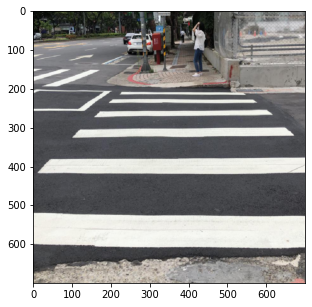

In [ ]:
fig = plt.figure()
fig.set_size_inches(5, 5)
plt.imshow(x[:, :, :].permute(1, 2, 0))

#### total classes

In [ ]:
classes = len(train_ds[0][1])
classes

## DataLoader

In [ ]:
train_dl = DataLoader(train_ds, shuffle=True, batch_size=10)
train_dl

In [ ]:
val_dl = DataLoader(val_ds, shuffle=False, batch_size=10)
val_dl

In [ ]:
test_dl = DataLoader(test_ds, shuffle=False, batch_size=10)
test_dl

### Pretrained Model Fine Tuning


### Training

#### Multitask learning
- safe to walk: binary. 0, 1 (X)
- roadway width: cat. 0, 1, 2, 3, 4, 5, 6, 7 (X)
- crossway signal: cat. 0, 1, 2
- traffic light: cat. 0, 1, 2
- car: binary. 0, 1
- scooter: binary. 0, 1
- bike: binary. 0, 1
- other obstacles: binary. 0, 1
- obstacles(clear): binary. 0, 1 (X)
- weather: cat. 0, 1, 2  
total classes = 3+3+1+1+1+1+3 = 13

#### Hyperparameters
- Choice of model (architecture)
- numbers of hidden layers
- numbers of  hidden layer filters
- Choice of optimizer
- learning rate (aka lr)


In [ ]:
num_classes = 22 # classes in y(expected to predict)
num_classes


22

#### finetuning

In [ ]:
n_hidden = 256
n_layers = 5  # functional n > 2


In [ ]:
my_block = nn.Sequential(
    nn.Linear(n_hidden, n_hidden),
    nn.ReLU(),
)

my_hidden = nn.Sequential(
    *[my_block for i in range(n_layers - 2)]
)


my_hidden

#### model selection

In [ ]:
train_model = 'vgg19'
# train_model = 'inception_v3'
train_model

'vgg19'

#### vgg19

In [ ]:
if train_model == 'vgg19':
  VGG19 = models.vgg19(pretrained=True)
  vgg19 = copy.deepcopy(VGG19)
  vgg19
  # Fine Tuning Full Connected Layer

  n_features = 25088
  model = copy.deepcopy(vgg19)
  my_clfr = nn.Sequential(
      nn.Linear(n_features, n_hidden),
      nn.ReLU(),
      my_hidden,
      nn.Linear(n_hidden, num_classes)
  )

  my_clfr
  vgg19.classifier = my_clfr
  vgg19
  vgg19.requires_grad = False
  vgg19.classifier.requires_grad = True
  vgg19.to(device)

#### inception v3

In [ ]:
if train_model == 'inception_v3':
  pre_model = models.inception_v3(pretrained=True)
  model = copy.deepcopy(pre_model)
  model
  # Fine Tuning Full Connected Layer

  model.AuxLogits.fc = nn.Linear(768, num_classes)
  model.fc = nn.Linear(2048, num_classes)
  
  model
  model.requires_grad = False
  model.AuxLogits.fc.requires_grad = True
  model.fc.requires_grad = True
  model.to(device)

In [ ]:
model

#### Loss functions

- Classification: CE, aka cross entropy, aka softmax
- Binary: BCE, aka binary cross entropy 

In [ ]:
# cat
roadway_width_cat_loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(roadway_cat_weight).to(device))
sign_cat_loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(sign_cat_weight).to(device))
traffic_light_cat_loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(traffic_light_cat_weight).to(device))
weather_cat_loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(weather_cat_weight).to(device))

# binary
safe_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(1-0.505)/0.505]).to(device))
car_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(1-0.188)/0.188]).to(device))
scooter_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(1-0.0764)/0.0764]).to(device))
bike_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([919/37]).to(device))
# other_obstacles_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([950/6]).to(device))
no_obstacle_in_crosswalk_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([242/714]).to(device))

#### Optimizer

In [ ]:
lr = 0.001
if train_model == 'vgg19':
  optimizer_fc = optim.Adam(vgg19.classifier.parameters(), lr=lr )
elif train_model == 'inception_v3':
  params = list(model.fc.parameters())+list(model.AuxLogits.fc.parameters())
  optimizer_fc = optim.Adam(model.fc.parameters(), lr=lr )
# optimizer_fc = optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.98)

#### num epochs

In [ ]:
n_epochs = 10 # number of epochs

In [ ]:
loss_his = [] # record loss history

In [ ]:
losses_1 = {}
losses_2 = {}
losses = {}
learning_log = []



running_loss=0
seen = 0




for i in range(n_epochs):
    for j, (x, y) in enumerate(train_dl):

      t1 = time.time()
      optimizer_fc.zero_grad()
      if torch.cuda.is_available():
        x = x.to(torch.device('cuda'))
        y = y.to(torch.device('cuda'))

      if train_model == 'vgg19':
        
        vgg19.train()        
        outputs = vgg19(x)
        losses["safe"] = safe_loss_fn(outputs[:, 0], y[:, 0].view(-1).float())
        losses["roadway_width_cat"] = roadway_width_cat_loss_fn(outputs[:, 1:9], y[:, 1].long())
        losses["sign"] = sign_cat_loss_fn(outputs[:, 9:12], y[:, 2].long())
        losses["traffic_light"] = traffic_light_cat_loss_fn(outputs[:, 12:15], y[:, 3].long())
        losses["car"] = car_loss_fn(outputs[:, 15], y[:, 4].view(-1).float())
        losses["scooter"] = scooter_loss_fn(outputs[:, 16], y[:, 5].view(-1).float())
        losses["bike"] = bike_loss_fn(outputs[:, 17], y[:, 6].view(-1).float())
        losses["no_obstacle_in_crosswalk"] = no_obstacle_in_crosswalk_loss_fn(outputs[:, 18], y[:, 7].view(-1).float())
        losses["weather_cat"] = weather_cat_loss_fn(outputs[:, 19:22], y[:, 8].long())
        loss = (
            losses["safe"]
            + losses["roadway_width_cat"]
            + losses["sign"]
            + losses["traffic_light"]
            + losses["car"]
            + losses["scooter"]
            + losses["bike"]
            + losses["no_obstacle_in_crosswalk"]
            + losses["weather_cat"]
            )    
      elif train_model == 'inception_v3':
        model.train()
        outputs, aux_outputs = model(x)
        losses_1["safe"] = safe_loss_fn(outputs[:, 0], y[:, 0].view(-1).float())
        losses_1["roadway_width_cat"] = roadway_width_cat_loss_fn(outputs[:, 1:9], y[:, 1].long())
        losses_1["sign"] = sign_cat_loss_fn(outputs[:, 9:12], y[:, 2].long())
        losses_1["traffic_light"] = traffic_light_cat_loss_fn(outputs[:, 12:15], y[:, 3].long())
        losses_1["car"] = car_loss_fn(outputs[:, 15], y[:, 4].view(-1).float())
        losses_1["scooter"] = scooter_loss_fn(outputs[:, 16], y[:, 5].view(-1).float())
        losses_1["bike"] = bike_loss_fn(outputs[:, 17], y[:, 6].view(-1).float())
        losses_1["no_obstacle_in_crosswalk"] = no_obstacle_in_crosswalk_loss_fn(outputs[:, 18], y[:, 7].view(-1).float())
        losses_1["weather_cat"] = weather_cat_loss_fn(outputs[:, 19:22], y[:, 8].long())
        loss1 = (            
             losses_1["safe"]
             + losses_1["roadway_width_cat"]
             + losses_1["sign"]
             + losses_1["traffic_light"]
             + losses_1["car"]
             + losses_1["scooter"]
             + losses_1["bike"]
             + losses_1["no_obstacle_in_crosswalk"]
             + losses_1["weather_cat"]
            )
        losses_2["safe"] = safe_loss_fn(aux_outputs[:, 0], y[:, 0].view(-1).float())
        losses_2["roadway_width_cat"] = roadway_width_cat_loss_fn(aux_outputs[:, 1:9], y[:, 1].long())
        losses_2["sign"] = sign_cat_loss_fn(aux_outputs[:, 9:12], y[:, 2].long())
        losses_2["traffic_light"] = traffic_light_cat_loss_fn(aux_outputs[:, 12:15], y[:, 3].long())
        losses_2["car"] = car_loss_fn(aux_outputs[:, 15], y[:, 4].view(-1).float())
        losses_2["scooter"] = scooter_loss_fn(aux_outputs[:, 16], y[:, 5].view(-1).float())
        losses_2["bike"] = bike_loss_fn(aux_outputs[:, 17], y[:, 6].view(-1).float())
        losses_2["no_obstacle_in_crosswalk"] =  no_obstacle_in_crosswalk_loss_fn(aux_outputs[:, 18], y[:, 7].view(-1).float())
        losses_2["weather_cat"] = weather_cat_loss_fn(aux_outputs[:, 19:22], y[:, 8].long())
        loss2 = (
             losses_2["safe"]
             + losses_2["roadway_width_cat"]
             + losses_2["sign"]
             + losses_2["traffic_light"]
             + losses_2["car"]
             + losses_2["scooter"]
             + losses_2["bike"]
             + losses_2["no_obstacle_in_crosswalk"]
             + losses_2["weather_cat"]
            )
        loss = loss1 + 0.4*loss2

      # record loss
      loss_his.append(loss)

      # back prop
      loss.backward()
      optimizer_fc.step()

     
      t2 = time.time()
      t_elapsed = t2 - t1
      seen = seen + x.size(0)
      learning_log.append({
          "epoch": i,
          "seen": seen,
          "loss": loss.item(),
      })

      print("epoch {:3d}  seen {:6d}  loss {:7.3f} time elapsed:{:5.1f}".format(i, seen, loss.item(),t_elapsed))
         




In [ ]:
plt.figure()
plt.plot(loss_his)
plt.show()

### Validation


In [ ]:
val_outputs = []
val_safe_labels = []
val_roadway_labels = []
val_sign_labels = []
val_traffic_light_labels = []
val_car_labels = []
val_scooter_labels = []
val_bike_labels = []
val_other_obstacles_labels = []
val_obstacle_labels = []
val_weather_labels = []
val_acc_history = []

if train_model == 'vgg19':
  vgg19.eval()
elif train_model == 'inception_v2':
  model.eval()


running_loss = 0.0
running_corrects = 0

for j, (x, y) in enumerate(val_dl):
    with torch.no_grad():
        t1 = time.time()
        if torch.cuda.is_available():
          x = x.to(torch.device('cuda'))
          y = y.to(torch.device('cuda'))
        # output = model(x)
        output = vgg19(x)
        val_outputs.append(output)
        val_safe_labels.append(y[:, 0])
        val_roadway_labels.append(y[:, 1])
        val_sign_labels.append(y[:, 2])
        val_traffic_light_labels.append(y[:, 3])
        val_car_labels.append(y[:, 4])
        val_scooter_labels.append(y[:,5])
        val_bike_labels.append(y[:,6])
        # val_other_obstacles_labels.append(y[:,5])
        val_obstacle_labels.append(y[:,7])
        val_weather_labels.append(y[:,8])
        t2 = time.time()
        t_elapsed = t2 - t1
        print(j, "time elapsed: {:5.1f}".format(t_elapsed))


0 time elapsed:   0.0
1 time elapsed:   0.5
2 time elapsed:   0.5
3 time elapsed:   0.5
4 time elapsed:   0.4
5 time elapsed:   0.5


In [ ]:
outputs_np = np.concatenate([o.cpu().numpy() for o in val_outputs])
outputs_np.shape

(57, 22)

In [ ]:
outputs_np

array([[ 1.0413475e+00, -8.6998920e+00, -7.7737063e-01, ...,
        -6.6419309e-01,  5.9596128e+00, -1.2046656e+01],
       [-8.4231180e-01, -2.0913897e+00, -7.5360578e-01, ...,
        -1.0251338e-02, -3.5919688e+00,  3.7257481e-01],
       [ 3.3073316e+00, -7.3966503e+00,  1.2728975e+00, ...,
         4.0743179e+00, -6.1406922e+00, -5.1179986e+00],
       ...,
       [-1.3599054e+00, -3.1641943e+00, -2.5160451e+00, ...,
        -1.5965009e+00, -3.0128951e+00,  1.6337575e+00],
       [ 6.5524179e-01, -5.6982350e+00, -1.0234151e-01, ...,
         1.6059706e+00, -6.4289641e+00, -2.6341560e+00],
       [-1.8407379e+00, -4.1286316e+00, -4.0841860e-01, ...,
         1.6098957e+00,  1.4354182e+00, -8.8621483e+00]], dtype=float32)

In [ ]:
outputs_np[:,0]

array([ 1.0413475 , -0.8423118 ,  3.3073316 , -0.02615174,  0.5941493 ,
       -0.347837  , -2.8135803 , -0.2829459 , -1.1349809 , -1.0769497 ,
        0.6134216 , -0.64252454,  0.60676056, -5.138899  ,  1.355941  ,
        0.7819177 ,  2.108624  , -0.34798795,  1.085762  ,  0.72085416,
       -0.02374536, -4.233409  , -1.4158356 ,  0.9087016 ,  3.2696743 ,
       -6.191485  ,  1.4283029 , -0.29611668,  1.3887792 ,  0.22984296,
        0.9014851 , -2.34546   , -0.29169148,  3.8126616 ,  0.48541692,
       -0.5653717 ,  4.263948  ,  0.83933085,  6.308351  , -2.539206  ,
       -0.12686804, -0.80083996,  1.9722018 ,  2.7240012 ,  2.2618895 ,
        0.3242329 ,  2.0275204 , -0.30753934,  0.4399881 ,  2.4469407 ,
        0.5693715 , -1.6318312 ,  1.1148221 ,  0.83926326, -1.3599054 ,
        0.6552418 , -1.8407379 ], dtype=float32)

In [ ]:
# outputs_np = np.concatenate([o.cpu().numpy() for o in val_outputs])
# predicts = 1 * (outputs_np > 0)

In [ ]:
result = {}

#### safe

In [ ]:
safe_pred = 1 * (outputs_np[:,0] > 0)
safe_pred

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0])

In [ ]:
val_y_safe = np.concatenate([l.cpu().numpy() for l in val_safe_labels])
val_y_safe

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0])

#### roadway width

In [ ]:
roadway_pred = np.argmax(outputs_np[:, 1:9], axis=1)
roadway_pred

In [ ]:
val_y_roadway = np.concatenate([l.cpu().numpy() for l in val_roadway_labels])
val_y_roadway

#### sign

In [ ]:
sign_pred = np.argmax(outputs_np[:, 9:12], axis=1)
# sign_pred = sign_pred.reshape(sign_pred.shape[0],1)
sign_pred

In [ ]:
val_y_sign = np.concatenate([l.cpu().numpy() for l in val_sign_labels])
val_y_sign

#### traffic light

In [ ]:
traffic_light_pred = np.argmax(outputs_np[:, 12:15], axis=1)
traffic_light_pred

In [ ]:
val_y_traffic_light = np.concatenate([l.cpu().numpy() for l in val_traffic_light_labels])
val_y_traffic_light

#### car

In [ ]:
car_pred = 1 * (outputs_np[:,15] > 0)
car_pred

In [ ]:
val_y_car = np.concatenate([l.cpu().numpy() for l in val_car_labels])
val_y_car

#### scooter

In [ ]:
scooter_pred = 1 * (outputs_np[:,16] > 0)
scooter_pred

In [ ]:
val_y_scooter = np.concatenate([l.cpu().numpy() for l in val_scooter_labels])
val_y_scooter

#### bike

In [ ]:
bike_pred = 1 * (outputs_np[:,17] > 0)
bike_pred

In [ ]:
val_y_bike = np.concatenate([l.cpu().numpy() for l in val_bike_labels])
val_y_bike

#### other obstacles

In [ ]:
# other_obstacles_pred = 1 * (outputs_np[:,9] > 0)
# other_obstacles_pred

In [ ]:
# val_y_other_obstacles = np.concatenate([l.cpu().numpy() for l in val_other_obstacles_labels])
# val_y_other_obstacles

#### obstacle

In [ ]:
obastacle_pred = 1 * (outputs_np[:,18] > 0)
# # obastacle_pred = obastacle_pred.reshape(obastacle_pred.shape[0],1)
obastacle_pred

In [ ]:
val_y_obstacle = np.concatenate([l.cpu().numpy() for l in val_obstacle_labels])
val_y_obstacle

#### weather

In [ ]:
weather_pred = np.argmax(outputs_np[:, 19:22], axis=1)
weather_pred

array([1, 2, 0, 1, 0, 0, 1, 0, 1, 1, 0, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 2, 0, 0])

In [ ]:
val_y_weather = np.concatenate([l.cpu().numpy() for l in val_weather_labels])
val_y_weather

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

#### safe figures

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(val_y_safe)):
    plt.subplot(12, 5, i + 1)
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(val_y_safe[i]) == int(safe_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_y_safe[i], safe_pred[i]), color=color)

In [ ]:
cm_safe = confusion_matrix(val_y_safe, safe_pred, normalize="true")
cm_safe

array([[0.60714286, 0.39285714],
       [0.27586207, 0.72413793]])

In [ ]:
val_acc_safe = np.sum(val_y_safe == safe_pred.T) / safe_pred.size
val_acc_safe
result['val_acc_safe'] = round(val_acc_safe,2)

#### roadway figure


In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(val_y_roadway)):
    plt.subplot(12, 5, i + 1)
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(val_y_roadway[i]) == int(roadway_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_y_roadway[i], roadway_pred[i]), color=color)

In [ ]:
cm_roadway = confusion_matrix(val_y_roadway, roadway_pred, normalize="true")
cm_roadway

In [ ]:
val_acc_roadway = np.sum(val_y_roadway == roadway_pred.T) / roadway_pred.size
val_acc_roadway
result['val_acc_roadway'] = round(val_acc_roadway,2)

#### sign fugures

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(val_y_sign)):
    plt.subplot(12, 5, i + 1)
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    if int(val_y_sign[i]) == int(sign_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_y_sign[i], sign_pred[i]), color=color)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cm_sign = confusion_matrix(val_y_sign, sign_pred, normalize="true")
cm_sign

array([[0.375     , 0.5625    , 0.0625    ],
       [0.16666667, 0.80555556, 0.02777778],
       [0.        , 0.6       , 0.4       ]])

In [ ]:
val_acc_sign = np.sum(val_y_sign == sign_pred.T) / sign_pred.size
val_acc_sign
result['val_acc_sign'] = round(val_acc_sign,2)

#### traffic light figure

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(val_y_traffic_light)):
    plt.subplot(12, 5, i + 1)
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.axis('off')
    plt.imshow(img.astype(np.uint8))
    if int(val_y_traffic_light[i]) == int(traffic_light_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_y_traffic_light[i], traffic_light_pred[i]), color=color)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cm_traffic_light = confusion_matrix(val_y_traffic_light, traffic_light_pred, normalize="true")
cm_traffic_light

array([[0.42857143, 0.28571429, 0.28571429],
       [0.29411765, 0.47058824, 0.23529412],
       [0.15151515, 0.12121212, 0.72727273]])

In [ ]:
val_acc_traffic_light = np.sum(val_y_traffic_light == traffic_light_pred.T) / traffic_light_pred.size
val_acc_traffic_light
result['val_acc_traffic_light'] = round(val_acc_traffic_light,2)

#### car figures

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(val_y_car)):
    plt.subplot(12, 5, i + 1)
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    if int(val_y_car[i]) == int(car_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Grpund Truth: {}  Predicted: {}".format(val_y_car[i], car_pred[i]), color=color)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cm_car = confusion_matrix(val_y_car, car_pred, normalize="true")
cm_car

array([[0.93617021, 0.06382979],
       [0.4       , 0.6       ]])

In [ ]:
val_acc_car = np.sum(val_y_car == car_pred.T) / car_pred.size
val_acc_car
result['val_acc_car'] = round(val_acc_car,2)

#### scooter fugures

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(val_y_scooter)):
    plt.subplot(12, 5, i + 1)
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    if int(val_y_scooter[i]) == int(scooter_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_y_scooter[i], scooter_pred[i]), color=color)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cm_scooter = confusion_matrix(val_y_scooter, scooter_pred, normalize="true")
cm_scooter

array([[0.94339623, 0.05660377],
       [0.25      , 0.75      ]])

In [ ]:
val_acc_scooter = np.sum(val_y_scooter == scooter_pred.T) / scooter_pred.size
val_acc_scooter
result['val_acc_scooter'] = round(val_acc_scooter,2)

#### bike figure

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(val_y_bike)):
    plt.subplot(12, 5, i + 1)
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    if int(val_y_bike[i]) == int(bike_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Grount Truth: {}  Predicted: {}".format(val_y_bike[i], bike_pred[i]), color=color)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cm_bike = confusion_matrix(val_y_bike, bike_pred, normalize="true")
cm_bike

array([[1. , 0. ],
       [0.5, 0.5]])

In [ ]:
val_acc_bike = np.sum(val_y_bike == bike_pred.T) / bike_pred.size
val_acc_bike
result['val_acc_bike'] = round(val_acc_bike,2)

#### other obstacles

In [ ]:
# fig = plt.figure()
# fig.set_size_inches(30, 30)
# for i in range(len(val_y_other_obstacles)):
#     plt.subplot(12, 5, i + 1)
#     img = val_ds[i][0].permute(1, 2, 0).numpy()
#     img = img - np.min(img)
#     img = 255 * img / np.max(img)
#     plt.imshow(img.astype(np.uint8))
#     if int(val_y_other_obstacles[i]) == int(predicts[i][5]):
#         color = "k"
#     else:
#         color = "r"
#     plt.title("Ground Truth: {}  Predicted: {}".format(val_y_other_obstacles[i], predicts[i][5]), color=color)

In [ ]:
# cm_other_obstacles = confusion_matrix(val_y_other_obstacles, predicts_other_obstalces, normalize="true")
# cm_other_obstacles

In [ ]:
# val_acc_other_obstacles = np.sum(val_y_other_obstacles == predicts_other_obstalces.T) / predicts_other_obstalces.size
# val_acc_other_obstacles
# result['val_acc_other_obstacles'] = round(val_acc_other_obstacles,2)

#### obstacle figures

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(val_y_obstacle)):
    plt.subplot(12, 5, i + 1)
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    if int(val_y_obstacle[i]) == int(obastacle_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_y_obstacle[i], obastacle_pred[i]), color=color)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cm_obstacle = confusion_matrix(val_y_obstacle, obastacle_pred, normalize="true")
cm_obstacle

array([[0.64285714, 0.35714286],
       [0.09302326, 0.90697674]])

In [ ]:
val_acc_obstacle = np.sum(val_y_obstacle == obastacle_pred.T) / obastacle_pred.size
val_acc_obstacle
result['val_acc_obstacle'] = round(val_acc_obstacle,2)

#### weather

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(val_y_weather)):
    plt.subplot(12, 5, i + 1)
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    if int(val_y_weather[i]) == int(weather_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_y_weather[i], weather_pred[i]), color=color)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cm_weather = confusion_matrix(val_y_weather, weather_pred, normalize="true")
cm_weather

array([[0.81395349, 0.04651163, 0.13953488],
       [0.21428571, 0.78571429, 0.        ],
       [0.        , 0.        , 0.        ]])

In [ ]:
val_acc_weather = np.sum(val_y_weather == weather_pred.T) / weather_pred.size
val_acc_weather
result['val_acc_weather'] = round(val_acc_weather,2)

#### result

In [ ]:
result

### Test


In [ ]:
test_outputs = []
test_safe_labels = []
test_roadway_labels = []
test_sign_labels = []
test_traffic_light_labels = []
test_car_labels = []
test_scooter_labels = []
test_bike_labels = []
test_other_obstacles_labels = []
test_obstacle_labels = []
test_weather_labels = []
test_acc_history = []


if train_model == 'vgg19':
  vgg19.eval()
elif train_model == 'inception_v2':
  model.eval()


running_loss = 0.0
running_corrects = 0

for j, (x, y) in enumerate(test_dl):
    with torch.no_grad():
        t1 = time.time()
        optimizer_fc.zero_grad()
        if torch.cuda.is_available():
          x = x.to(torch.device('cuda'))
          y = y.to(torch.device('cuda'))
        # output = model(x)
        output = vgg19(x)
        test_outputs.append(output)
        test_safe_labels.append(y[:, 0])
        test_roadway_labels.append(y[:, 1])
        test_sign_labels.append(y[:, 2])
        test_traffic_light_labels.append(y[:, 3])
        test_car_labels.append(y[:, 4])
        test_scooter_labels.append(y[:,5])
        test_bike_labels.append(y[:,6])
        # val_other_obstacles_labels.append(y[:,5])
        test_obstacle_labels.append(y[:,7])
        test_weather_labels.append(y[:,8])
        t2 = time.time()
        t_elapsed = t2 - t1
        print(j, "time elapsed: {:5.1f}".format(t_elapsed))


In [ ]:
test_outputs_np = np.concatenate([o.cpu().numpy() for o in test_outputs])
test_outputs_np.shape

In [ ]:
test_outputs_np

In [ ]:
test_outputs_np[:,0]

In [ ]:
test_result = {}

#### safe

In [ ]:
test_safe_pred = 1 * (test_outputs_np[:,0] > 0)

test_safe_pred

In [ ]:
test_y_safe = np.concatenate([l.cpu().numpy() for l in test_safe_labels])
test_y_safe

#### roadway width

In [ ]:
test_roadway_pred = np.argmax(test_outputs_np[:, 1:9], axis=1)
test_roadway_pred

In [ ]:
test_y_roadway = np.concatenate([l.cpu().numpy() for l in test_roadway_labels])
test_y_roadway

#### sign

In [ ]:
test_sign_pred = np.argmax(test_outputs_np[:, 9:12], axis=1)
test_sign_pred

In [ ]:
test_y_sign = np.concatenate([l.cpu().numpy() for l in test_sign_labels])
test_y_sign

#### traffic light

In [ ]:
test_traffic_light_pred = np.argmax(test_outputs_np[:, 12:15], axis=1)
test_traffic_light_pred

In [ ]:
test_y_traffic_light = np.concatenate([l.cpu().numpy() for l in test_traffic_light_labels])
test_y_traffic_light

#### car

In [ ]:
test_car_pred = 1 * (test_outputs_np[:,15] > 0)
test_car_pred

In [ ]:
test_y_car = np.concatenate([l.cpu().numpy() for l in test_car_labels])
test_y_car

#### scooter

In [ ]:
test_scooter_pred = 1 * (test_outputs_np[:,16] > 0)
test_scooter_pred

In [ ]:
test_y_scooter = np.concatenate([l.cpu().numpy() for l in test_scooter_labels])
test_y_scooter

#### bike

In [ ]:
test_bike_pred = 1 * (test_outputs_np[:,17] > 0)
test_bike_pred

In [ ]:
test_y_bike = np.concatenate([l.cpu().numpy() for l in test_bike_labels])
test_y_bike

#### other obstacles

In [ ]:
# other_obstacles_pred = 1 * (outputs_np[:,9] > 0)
# other_obstacles_pred

In [ ]:
# val_y_other_obstacles = np.concatenate([l.cpu().numpy() for l in val_other_obstacles_labels])
# val_y_other_obstacles

#### obstacle

In [ ]:
test_obastacle_pred = 1 * (test_outputs_np[:,18] > 0)
test_obastacle_pred

In [ ]:
test_y_obstacle = np.concatenate([l.cpu().numpy() for l in test_obstacle_labels])
test_y_obstacle

#### weather

In [ ]:
test_weather_pred = np.argmax(test_outputs_np[:, 19:22], axis=1)
test_weather_pred

In [ ]:
test_y_weather = np.concatenate([l.cpu().numpy() for l in test_weather_labels])
test_y_weather

#### restult

In [ ]:
result = {}

#### safe figures

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(test_y_safe)):
    plt.subplot(12, 5, i + 1)
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(test_y_safe[i]) == int(test_safe_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_y_safe[i], test_safe_pred[i]), color=color)

In [ ]:
test_cm_safe = confusion_matrix(test_y_safe, test_safe_pred, normalize="true")
test_cm_safe

In [ ]:
test_acc_safe = np.sum(test_y_safe == test_safe_pred.T) / test_safe_pred.size
test_acc_safe
test_result['test_acc_safe'] = round(test_acc_safe,2)

#### roadway figure


In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(test_y_roadway)):
    plt.subplot(12, 5, i + 1)
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    if int(test_y_roadway[i]) == int(test_roadway_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_y_roadway[i], test_roadway_pred[i]), color=color)

In [ ]:
test_cm_roadway = confusion_matrix(test_y_roadway, test_roadway_pred, normalize="true")
test_cm_roadway

In [ ]:
test_acc_roadway = np.sum(test_y_roadway == test_roadway_pred.T) / test_roadway_pred.size
test_acc_roadway
test_result['val_acc_roadway'] = round(test_acc_roadway,2)

#### sign fugures

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(test_y_sign)):
    plt.subplot(12, 5, i + 1)
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    if int(test_y_sign[i]) == int(test_sign_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_y_sign[i], test_sign_pred[i]), color=color)

In [ ]:
test_cm_sign = confusion_matrix(test_y_sign, test_sign_pred, normalize="true")
test_cm_sign

In [ ]:
test_acc_sign = np.sum(val_y_sign == sign_pred.T) / test_sign_pred.size
test_acc_sign
test_result['test_acc_sign'] = round(test_acc_sign,2)

#### traffic light figure

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(test_y_traffic_light)):
    plt.subplot(12, 5, i + 1)
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    if int(test_y_traffic_light[i]) == int(test_traffic_light_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_y_traffic_light[i], test_traffic_light_pred[i]), color=color)

In [ ]:
test_cm_traffic_light = confusion_matrix(test_y_traffic_light, test_traffic_light_pred, normalize="true")
test_cm_traffic_light

In [ ]:
test_acc_traffic_light = np.sum(test_y_traffic_light == test_traffic_light_pred.T) / test_traffic_light_pred.size
test_acc_traffic_light
test_result['val_acc_traffic_light'] = round(test_acc_traffic_light,2)

#### car figures

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(test_y_car)):
    plt.subplot(12, 5, i + 1)
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    if int(test_y_car[i]) == int(test_car_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_y_car[i], test_car_pred[i]), color=color)

In [ ]:
test_cm_car = confusion_matrix(test_y_car, test_car_pred, normalize="true")
test_cm_car

In [ ]:
test_acc_car = np.sum(test_y_car == test_car_pred.T) / test_car_pred.size
test_acc_car
test_result['test_acc_car'] = round(test_acc_car,2)

#### scooter fugures

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(test_y_scooter)):
    plt.subplot(12, 5, i + 1)
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    if int(test_y_scooter[i]) == int(test_scooter_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_y_scooter[i], test_scooter_pred[i]), color=color)

In [ ]:
test_cm_scooter = confusion_matrix(test_y_scooter, test_scooter_pred, normalize="true")
test_cm_scooter

In [ ]:
test_acc_scooter = np.sum(test_y_scooter == test_scooter_pred.T) / test_scooter_pred.size
test_acc_scooter
test_result['test_acc_scooter'] = round(test_acc_scooter,2)

#### bike figure

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(test_y_bike)):
    plt.subplot(12, 5, i + 1)
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    if int(test_y_bike[i]) == int(test_bike_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_y_bike[i], test_bike_pred[i]), color=color)

In [ ]:
test_cm_bike = confusion_matrix(test_y_bike, test_bike_pred, normalize="true")
test_cm_bike
# 左上 label == 0 predict ==0 右上label==0 predict==1
# 左下 label == 1 predict ==0 右下label==1 predict==1

In [ ]:
test_acc_bike = np.sum(test_y_bike == test_bike_pred.T) / test_bike_pred.size
test_acc_bike
test_result['test_acc_bike'] = round(test_acc_bike,2)

#### other obstacles

In [ ]:
# fig = plt.figure()
# fig.set_size_inches(30, 30)
# for i in range(len(val_y_other_obstacles)):
#     plt.subplot(12, 5, i + 1)
#     img = val_ds[i][0].permute(1, 2, 0).numpy()
#     img = img - np.min(img)
#     img = 255 * img / np.max(img)
#     plt.imshow(img.astype(np.uint8))
#     plt.axis('off')
#     if int(val_y_other_obstacles[i]) == int(predicts[i][5]):
#         color = "k"
#     else:
#         color = "r"
#     plt.title("Ground Truth: {}  Predicted: {}".format(val_y_other_obstacles[i], predicts[i][5]), color=color)

In [ ]:
# cm_other_obstacles = confusion_matrix(val_y_other_obstacles, predicts_other_obstalces, normalize="true")
# cm_bike

In [ ]:
# val_acc_other_obstacles = np.sum(val_y_other_obstacles == predicts_other_obstalces.T) / predicts_other_obstalces.size
# val_acc_other_obstacles
# result['val_acc_other_obstacles'] = round(val_acc_other_obstacles,2)

#### obstacle figures

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(test_y_obstacle)):
    plt.subplot(12, 5, i + 1)
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    if int(test_y_obstacle[i]) == int(test_obastacle_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_y_obstacle[i], test_obastacle_pred[i]), color=color)

In [ ]:
test_cm_obstacle = confusion_matrix(test_y_obstacle, test_obastacle_pred, normalize="true")
test_cm_obstacle

In [ ]:
test_acc_obstacle = np.sum(test_y_obstacle == test_obastacle_pred.T) / test_obastacle_pred.size
test_acc_obstacle
test_result['test_acc_obstacle'] = round(test_acc_obstacle,2)

#### weather

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 40)
for i in range(len(test_y_weather)):
    plt.subplot(12, 5, i + 1)
    img = test_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    if int(test_y_weather[i]) == int(test_weather_pred[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(test_y_weather[i], test_weather_pred[i]), color=color)

In [ ]:
test_cm_weather = confusion_matrix(test_y_weather, test_weather_pred, normalize="true")
test_cm_weather

In [ ]:
test_acc_weather = np.sum(test_y_weather == test_weather_pred.T) / test_weather_pred.size
test_acc_weather
test_result['test_acc_weather'] = round(test_acc_weather,2)

#### result

In [ ]:
test_result

### Save & Load

#### save model

In [ ]:
# torch.save(vgg19.state_dict(), '柏叡/vgg19_epch30')

In [ ]:
torch.save(vgg19, '柏叡/vgg19_n_hidden{}'.format(n_hidden))

#### load model

In [ ]:
vgg19 = torch.load('柏叡/vgg19_epch30')


In [ ]:
# vgg19

In [ ]:
# vgg19.classifier = my_clfr
# vgg19.load_state_dict(torch.load('柏叡/vgg19_epch30'))

### Transfer learning

In [ ]:
# model = models.vgg16(pretrained=True)
# TODO: Try other model
pre_model = models.inception_v3(pretrained=True)
pre_model


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
model = copy.deepcopy(pre_model)
if torch.cuda.is_available():
  print('cuda')
  model.to(torch.device('cuda'))
model.AuxLogits.fc = nn.Flatten()
model.fc = nn.Flatten()

cuda


In [ ]:
# pre_model = models.mobilenet_v3_small(pretrained=True)
# pre_model

In [ ]:
# model = copy.deepcopy(pre_model)
# model.classifier = nn.Flatten()
# model

In [ ]:
n_epochs = 1


train_outputs = []
train_safe_labels = []
train_dist_labels = []
train_weather_labels = []

for i in range(n_epochs):
    for j, (x, y) in enumerate(train_dl):
        with torch.no_grad():
            x = x.to(torch.device('cuda'))
            # x.to('cuda')
            output = model(x)
            print(i, j, output.size())
            train_outputs.append(output)
            train_safe_labels.append(y[:, 0])
            train_dist_labels.append(y[:, 1])
            train_weather_labels.append(y[:, 2])

In [ ]:

train_outputs_np = np.concatenate([o.cpu().numpy() for o in train_outputs])
train_outputs_np.shape

In [ ]:
train_outputs

In [ ]:

val_outputs = []
val_safe_labels = []
val_car_labels = []
# val_weather_labels = []

model.eval()

for j, (x, y) in enumerate(val_dl):
    with torch.no_grad():
        x = x.to(torch.device('cuda'))
        output = model(x)
        print( j, output.size())
        val_outputs.append(output)
        val_safe_labels.append(y[:, 0])
        val_car_labels.append(y[:, 1])
        # val_weather_labels.append(y[:, 2])

In [ ]:
val_car_labels

#### SVM

Support vector machine 

In [ ]:
train_y = np.concatenate([l.numpy() for l in train_safe_labels])

clf = SVC()
clf.fit(train_outputs_np, train_y)

In [ ]:
outputs_np = np.concatenate([o.cpu().numpy() for o in val_outputs])
predicts = clf.predict(outputs_np)
predicts

In [ ]:
val_y_safe = np.concatenate([l.numpy() for l in val_safe_labels])
val_y_safe

In [ ]:
fig = plt.figure()
fig.set_size_inches(15, 15)
for i in range(50):
    plt.subplot(10, 5, i + 1)
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(val_y[i]) == int(predicts[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_y[i], predicts[i]), color=color)

In [ ]:
val_acc = np.sum(val_y == predicts) / predicts.size
val_acc

In [ ]:
len(val_y)

#### Confusion matrix

TP FP
FN TN

In [ ]:
cm = confusion_matrix(val_y, predicts, normalize="true")
cm

#### Fine-tuning

In [ ]:
# TODO: Try other model
pre_model = models.mobilenet_v3_small(pretrained=True)

In [ ]:
my_classifier = nn.Sequential(
    nn.Linear(576, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1),
)


model = copy.deepcopy(pre_model)
model.classifier = my_classifier
model

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_r

In [ ]:
model.requires_grad = False
model.classifier.requires_grad = True

#### Training!

In [ ]:
n_epochs = 2

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()  # Bineary cross entropy 


model.train()

for i in range(n_epochs):
    for j, (x, y) in enumerate(train_dl):
        t1 = time.time()
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y[:, 0, None].float())
        loss.backward()
        optimizer.step()
        t2 = time.time()
        t_elapsed = t2 - t1
        print(i, j, "loss: {:5.3f}  time elapsed: {:5.1f}".format(loss.item(), t_elapsed))



0 0 loss: 0.694  time elapsed:   9.1
0 1 loss: 0.781  time elapsed:   8.5
0 2 loss: 0.765  time elapsed:   8.7


KeyboardInterrupt: ignored

#### Validation

In [ ]:
val_outputs = []

model.eval()

for j, (x, y) in enumerate(val_dl):
    with torch.no_grad():
        t1 = time.time()
        output = model(x)
        val_outputs.append(output)
        t2 = time.time()
        t_elapsed = t2 - t1
        print(j, "time elapsed: {:5.1f}".format(t_elapsed))

0 time elapsed:   0.4
1 time elapsed:   0.4
2 time elapsed:   0.4
3 time elapsed:   0.4
4 time elapsed:   0.4
5 time elapsed:   0.3


In [ ]:
outputs_np = np.concatenate([o.numpy() for o in val_outputs])
predicts = 1 * (outputs_np > 0)

NameError: ignored

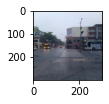

In [ ]:
fig = plt.figure()
fig.set_size_inches(15, 15)
for i in range(50):
    plt.subplot(10, 5, i + 1)
    img = val_ds[i][0].permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = 255 * img / np.max(img)
    plt.imshow(img.astype(np.uint8))
    if int(val_y[i]) == int(predicts[i]):
        color = "k"
    else:
        color = "r"
    plt.title("Ground Truth: {}  Predicted: {}".format(val_y[i], predicts[i]), color=color)

In [ ]:
cm = confusion_matrix(val_y, predicts, normalize="true")
cm

array([[0., 1.],
       [0., 1.]])

In [ ]:
val_acc = np.sum(val_y == predicts.T) / predicts.size
val_acc

0.56